# Park clusters  in Chittenden County, VT
The goal is to identify the densest cluster of parks in Chittenden County - specifically, the park that has the most number of parks nearby. The clusters will be useful in the planning of community events such as scavenger hunts or Pokemon Go excursions wherein participants travel from park to park. The data acquisition and analysis techniques used should be easily transferable to other types of venues and geographical areas.

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [2]:
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [3]:
import requests
import urllib.parse
import folium
import geopy.distance
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

## Communities in Chittenden County
The parks of interest are those located in Chittenden County as defined by the list of cities, towns, and villages on the [Chittenden County Wikipedia page](https://en.wikipedia.org/wiki/Chittenden_County,_Vermont). The lists are small and embedded in the DOM in such a way that their elements are more conveniently extracted manually than by scraping. Since we're searching worldwide, we also specify these are Vermont communities. We combine them under an overarching label called _communities_ (Wikipedia's terminology) and place them in a list, removing any duplicates.

In [4]:
cities = ["Burlington, VT", "South Burlington, VT", "Winooski, VT"]
towns = ["Bolton, VT", "Charlotte, VT", "Colchester, VT", "Essex, VT", "Hinesburg, VT", "Huntington, VT", "Jericho, VT", "Milton, VT", "Richmond, VT", "Shelburne, VT", "St. George, VT", "Underhill, VT", "Westford, VT", "Williston, VT"]
villages = ["Essex Junction, VT", "Jericho, VT"]

communities = cities + towns + villages
communities = list(set(communities)) # Deduplicate
communities.sort()

print(communities)

['Bolton, VT', 'Burlington, VT', 'Charlotte, VT', 'Colchester, VT', 'Essex Junction, VT', 'Essex, VT', 'Hinesburg, VT', 'Huntington, VT', 'Jericho, VT', 'Milton, VT', 'Richmond, VT', 'Shelburne, VT', 'South Burlington, VT', 'St. George, VT', 'Underhill, VT', 'Westford, VT', 'Williston, VT', 'Winooski, VT']


## Using Foursquare to find parks
The Foursquare services require authentication. For my analysis, I used the credentials associated with my personal Foursquare account. **To proceed further, you will need to replace the placeholders in the following cell with credentials of your own**.

You can get credentials by creating a free developer account on the [Foursquare website](https://foursquare.com).

In [5]:
CLIENT_ID = "???"
CLIENT_SECRET = "???"
VERSION = "20191223"

We ultimately want to search for venues, but to filter that search we need to tell Foursquare what _category_ of venue we are interested in: in our case, we need the `categoryId` for _park_. Foursquare provides an [endpoint](https://developer.foursquare.com/docs/api/venues/categories) for its category hierarchy, but since we only have one category, we can grab it manually from the [categories page](https://developer.foursquare.com/docs/resources/categories).

In [6]:
categoryId = "4bf58dd8d48988d163941735"

The `explore` API endpoint finds venues by type (parks, for example) near a _place_ which seemingly maps cleanly to the Wikipedia notion of _communitiy_. We hit the endpoint once per community and accumulate the results in a dataframe.

For preparing the data, a number of parks that don't have their communities listed in Foursquare; we filter these out. Furthermore the filtering of the search to a specific _place_ isn't exact; as a result we deduplicate.

In [7]:
LIMIT = 100 # Adequate at least for a small rural area
urlTemplate = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&near={}&categoryId={}&limit={}"

# Accumulate all items raw first, this separates the API hits from the
# rest of the data manipulation. If we don't modify "items" in subsequent
# blocks, we don't have to hit the API again once this part is right.

items = []
for community in communities:
    # Properly encode spaces and other non-URL-compliant characters in the
    # community names
    urlEncodedCommunity = urllib.parse.quote(community)
    url = urlTemplate.format(CLIENT_ID, CLIENT_SECRET, VERSION, urlEncodedCommunity, categoryId, LIMIT)
    items = items + requests.get(url).json()["response"]["groups"][0]["items"]

In [8]:
venues = []
for item in items:
    city = item["venue"]["location"].get("city", "") # Sometimes no city
    state = item["venue"]["location"].get("state", "") # Could be problematic outside US...
    venues.append([
        city + ", " + state,
        item["venue"]["name"],
        item["venue"]["location"]["lat"],
        item["venue"]["location"]["lng"]])

dataframe = pd.DataFrame(venues, columns = ["Community", "Name", "Latitude", "Longitude"])
dataframe = dataframe[dataframe["Community"].isin(communities)] # Filter bogus communities
dataframe = dataframe.sort_values(["Community", "Name"])
dataframe = dataframe.drop_duplicates()

dataframe.head()

,Community,Name,Latitude,Longitude
14,"Bolton, VT",Bolton Potholes,44.374560,-72.876388
54,"Burlington, VT",Battery Park,44.481381,-73.220100
75,"Burlington, VT",Bizarre Memorial Park,44.450560,-73.209330
45,"Burlington, VT",Burlington Skate Park,44.481244,-73.222418
34,"Burlington, VT",Burlington Waterfront Dog Park,44.484982,-73.226295


## Folium visualization of complete data set
For convenience here and in later analysis, we capture the minimum and maximum latitudes and longitudes.

In [9]:
minimumLatitude = dataframe["Latitude"].min()
minimumLongitude = dataframe["Longitude"].min()
maximumLatitude = dataframe["Latitude"].max()
maximumLongitude = dataframe["Longitude"].max()

print("minimumLatitude={}, minimumLongitude={}, maximumLatitude={}, maximumLongitude={}"
    .format(minimumLatitude, minimumLongitude, maximumLatitude, maximumLongitude))

minimumLatitude=44.278400175514705, minimumLongitude=-73.28116608010764, maximumLatitude=44.63749165591372, maximumLongitude=-72.87638842029503


In [10]:
# WARNING: More robust would be to derive the zoom from the coordinates
ZOOM_START = 10

# WARNING: More robust would be to leverage geopy or similar; distance between degrees longitude depends on latitude
centerLatitude = (maximumLatitude + minimumLatitude) / 2
centerLongitude = (maximumLongitude + minimumLongitude) / 2

fullMap = folium.Map(location = [centerLatitude, centerLongitude], zoom_start = ZOOM_START)

# Create a unique color for each community
x = np.arange(len(communities))
ys = [i + x + (i * x) ** 2 for i in range(len(communities))]
rainbow = [colors.rgb2hex(i) for i in cm.rainbow(np.linspace(0, 1, len(ys)))]

for community, name, latitude, longitude in zip(dataframe["Community"], dataframe["Name"], dataframe["Latitude"], dataframe["Longitude"]):
    label = "{} ({})".format(name, community)
    color = rainbow[communities.index(community)]
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = folium.Popup(label, parse_html = True),
        color = color,
        fill = True,
        fill_color = color,
        fill_opacity = 0.7).add_to(fullMap)

fullMap

## Finding the venue nearest the most others
The endgame is to find the venue that has the most other venues near it, where _nearness_ means "within some fixed number of kilometers away, which we will specify". We know the latitudes and longitudes of all the venues, but calculating the distances between such coordinates is [rather complicated and interesting](https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616). Suffice it to say here the Euclidean notion of distance will not help. That is why we resort to geopy.

We calculate the nearby venues for every venue, and add the result to the dataframe.

In [11]:
RADIUS = 1.1 # "Nearness" distance in kilometers

def nearbyVenueIndexes(dataframe, latitude, longitude):
    result = []
    origin = (latitude, longitude)
    for index, row in dataframe.iterrows():
        point = (row["Latitude"], row["Longitude"])
        if geopy.distance.distance(origin, point).km <= RADIUS:
            result.append(index)
    return result

nearbyCounts = []
for index, row in dataframe.iterrows():
    indexes = nearbyVenueIndexes(dataframe, row["Latitude"], row["Longitude"])
    nearbyCounts.append(len(indexes) - 1)

nearbyDataframe = dataframe.copy()
nearbyDataframe["Nearby"] = nearbyCounts
nearbyDataframe = nearbyDataframe.sort_values(["Nearby", "Community", "Name"], ascending = [False, True, True])
nearbyDataframe.head()

,Community,Name,Latitude,Longitude,Nearby
54,"Burlington, VT",Battery Park,44.481381,-73.220100,10
4,"Burlington, VT",City Hall Park,44.476587,-73.213660,8
45,"Burlington, VT",Burlington Skate Park,44.481244,-73.222418,7
69,"Burlington, VT",Hoefl Park,44.475926,-73.221590,7
76,"Burlington, VT",The Pumpkin Regatta,44.479967,-73.222390,7


And at the top of the list, the winner is... **Battery Park**!

In [12]:
winner = nearbyDataframe.iloc[0]
winner["Name"]

'Battery Park'

Just out of curiousity, let's see a histogram of the number of venues nearby every venue. Not bothering with labels and other niceties here.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17147b2cc0>]], dtype=object)

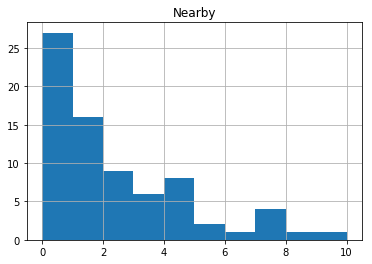

In [16]:
nearbyDataframe.hist(column = "Nearby", bins = nearbyDataframe["Nearby"].max())

## Map of the playing field
We have identified the venue in the center, but that by itself is an incomplete deliverable. Our stakeholders will want to know all the venues that comprise the playing field. We find the playing field and show it as a dataframe and also on a map.

In [14]:
fieldIndexes = nearbyVenueIndexes(dataframe, winner["Latitude"], winner["Longitude"])
field = dataframe[dataframe.index.isin(fieldIndexes)]
field

,Community,Name,Latitude,Longitude
54,"Burlington, VT",Battery Park,44.481381,-73.220100
45,"Burlington, VT",Burlington Skate Park,44.481244,-73.222418
34,"Burlington, VT",Burlington Waterfront Dog Park,44.484982,-73.226295
74,"Burlington, VT",Champlain Street Park,44.474096,-73.217073
4,"Burlington, VT",City Hall Park,44.476587,-73.213660
69,"Burlington, VT",Hoefl Park,44.475926,-73.221590
70,"Burlington, VT",Little Park,44.487742,-73.210678
77,"Burlington, VT",Pomeroy Park,44.484750,-73.207648
71,"Burlington, VT",Roosevelt Park,44.489126,-73.212089
76,"Burlington, VT",The Pumpkin Regatta,44.479967,-73.222390


In [15]:
fieldMap = folium.Map(location = [centerLatitude, centerLongitude], zoom_start = ZOOM_START)

for name, latitude, longitude in zip(field["Name"], field["Latitude"], field["Longitude"]):
    label = "{} ({})".format(name, community)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = folium.Popup(label, parse_html = True),
        fill = True,
        fill_opacity = 0.7).add_to(fieldMap)

fieldMap